In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

In [2]:
df = pd.read_csv('black_friday_data_kaggle.csv', error_bad_lines=False)
df.head()

,Unnamed: 0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,1000001,P00069042,F,0-17,10,A,2,0,-1,NaN,NaN,8370
1,1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,2,1000001,P00087842,F,0-17,10,A,2,0,-1,NaN,NaN,1422
3,3,1000001,P00085442,F,0-17,10,A,2,0,-1,14.0,NaN,1057
4,4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.fillna(0, inplace=True)
df.Product_Category_2 = df.Product_Category_2.astype(int)
df.Product_Category_3 = df.Product_Category_3.astype(int)

le = LabelEncoder()
df['User_ID'] = le.fit_transform(df['User_ID'])
# df['Product_ID'] = le.fit_transform(df['Product_ID'])
df['Age'] = le.fit_transform(df['Age'])
df['Gender'] = le.fit_transform(df['Gender'])
df['City_Category'] = le.fit_transform(df['City_Category'])
df['Stay_In_Current_City_Years'] = le.fit_transform(df['Stay_In_Current_City_Years'])
df=df.drop('Unnamed: 0', axis=1)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,P00069042,0,0,10,0,2,0,-1,0,0,8370
1,0,P00248942,0,0,10,0,2,0,1,6,14,15200
2,0,P00087842,0,0,10,0,2,0,-1,0,0,1422
3,0,P00085442,0,0,10,0,2,0,-1,14,0,1057
4,1,P00285442,1,6,16,2,4,0,8,0,0,7969


In [4]:
target = (df.groupby(by='Product_ID', as_index=False)
          .agg({'Purchase': lambda x: x.max(),
                'Product_Category_1': lambda x: x.value_counts().idxmax(),
                'Product_Category_2': lambda x: x.median(),
                'User_ID': pd.Series.nunique,
#                 'Gender': lambda x: x.value_counts().idxmax(),
#                 'Age': lambda x: x.value_counts().idxmax()
#                 'City_Category': lambda x: x.value_counts().idxmax(),
#                 'Occupation': lambda x: x.value_counts().idxmax(),
                'Product_Category_3': lambda x: x.value_counts().idxmax()
                }))

target['Log_Num_Users'], target['Log_Purchase'] = np.log(
    target.User_ID), np.log(target.Purchase)

In [5]:
df_train = target[target.Product_Category_1 != -1]
df_test = target[target.Product_Category_1 == -1]
y = df_train['Product_Category_1']
X = df_train.drop('Product_Category_1', axis=1)
X = X.drop('Product_ID', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
Y_train_pred = rf.predict(X_train)
print("Accuracy Score of Random Forests on train set",rf.score(X_train, y_train)*100,'%')
Y_test_pred_rf = rf.predict(X_test)
print("Accuracy Score of Random Forests on test set",rf.score(X_test, y_test)*100,'%')
# accuracy_score(y_test, Y_test_pred)

Accuracy Score of Random Forests on train set 100.0 %
Accuracy Score of Random Forests on test set 94.11027568922306 %


In [8]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("Accuracy Score of Decision Tree on train set",clf.score(X_train, y_train)*100,'%')
print("Accuracy Score of Decision Tree on test set",clf.score(X_test, y_test)*100,'%')

Accuracy Score of Decision Tree on train set 100.0 %
Accuracy Score of Decision Tree on test set 95.6140350877193 %


In [9]:
kfold = KFold(n_splits=30, random_state=0)
bag = BaggingClassifier(base_estimator=clf, n_estimators=100,
                        random_state=42, max_samples=0.5, max_features=0.5)
bag.fit(X_train, y_train)
results = cross_val_score(bag, X, y, cv=kfold)
print('Bagging: ', results.mean())

Bagging:  0.957777777777778


In [10]:
print("Accuracy Score of Bagging on train set", bag.score(X_train, y_train)*100,'%')
print("Accuracy Score of Bagging on test set",bag.score(X_test, y_test)*100,'%')

Accuracy Score of Bagging on train set 98.70210135970335 %
Accuracy Score of Bagging on test set 94.9874686716792 %


In [11]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('clf', clf), ('bag', bag)],
    voting='hard')

voting_clf.fit(X_train, y_train)

print("Accuracy Score of Voting Classifier on test set", voting_clf.score(X_train, y_train)*100,'%')
print("Accuracy Score of Voting Classifier on test set", voting_clf.score(X_test, y_test)*100,'%')

Accuracy Score of Voting Classifier on test set 100.0 %
Accuracy Score of Voting Classifier on test set 95.6140350877193 %


In [12]:
def rmsle(pred_val, act_val):
    pred_val = np.array(pred_val)
    act_val = np.array(act_val)
    
    log_predict, log_actual = np.log(pred_val + 1), np.log(act_val + 1)
    
    diff = np.square(log_predict - log_actual)
    mean_diff = diff.mean()
    return np.sqrt(mean_diff)

rmsle_scorer = make_scorer(rmsle)
# the lesser the better
%time score = cross_val_score(rf, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Random Forest: ", "Score= {0:.5f}".format(score))

%time score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Decision Tree: ", "Score= {0:.5f}".format(score))

%time score = cross_val_score(bag, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Bagging with Decision Tree: ", "Score= {0:.5f}".format(score))

%time score = cross_val_score(voting_clf, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Voting Classifier: ", "Score= {0:.5f}".format(score))

CPU times: user 5.1 s, sys: 27.3 ms, total: 5.13 s
Wall time: 5.18 s
Random Forest:  Score= 0.20589
CPU times: user 192 ms, sys: 1.95 ms, total: 194 ms
Wall time: 198 ms
Decision Tree:  Score= 0.21630
CPU times: user 4.92 s, sys: 19.2 ms, total: 4.94 s
Wall time: 4.98 s
Bagging with Decision Tree:  Score= 0.19815
CPU times: user 10.2 s, sys: 41.7 ms, total: 10.3 s
Wall time: 10.4 s
Voting Classifier:  Score= 0.19203


Feature ranking:
              feature  importance
0            Purchase    0.426791
5        Log_Purchase    0.399147
1  Product_Category_2    0.071066
2             User_ID    0.046680
4       Log_Num_Users    0.043640
3  Product_Category_3    0.012676


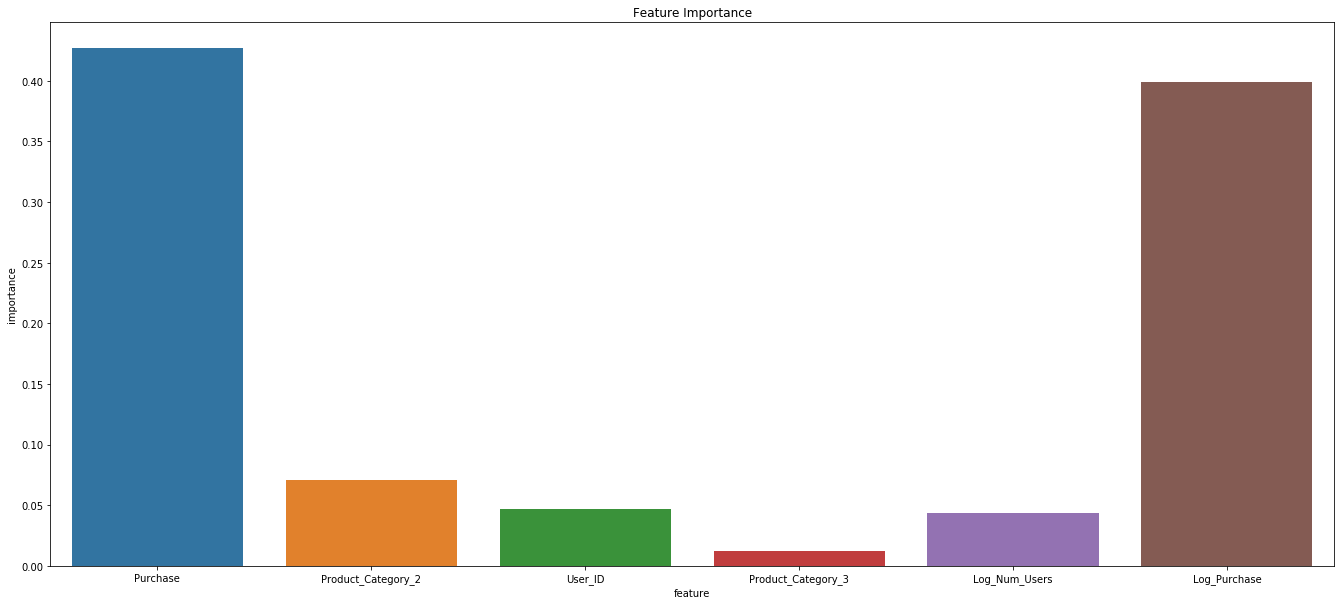

In [13]:
# Feature Importance Exploration for RF
importances = rf.feature_importances_
imp = pd.DataFrame()
imp['feature'], imp['importance'] = X_train.columns, importances
print("Feature ranking:")
print(imp.sort_values(by='importance', ascending=False))
plt.figure(figsize=(23, 10))
sns.barplot(x='feature', y='importance', data=imp)
plt.title('Feature Importance')
plt.show()

Feature ranking:
              feature  importance
5        Log_Purchase    0.535518
0            Purchase    0.400822
4       Log_Num_Users    0.021490
2             User_ID    0.021312
1  Product_Category_2    0.019418
3  Product_Category_3    0.001439


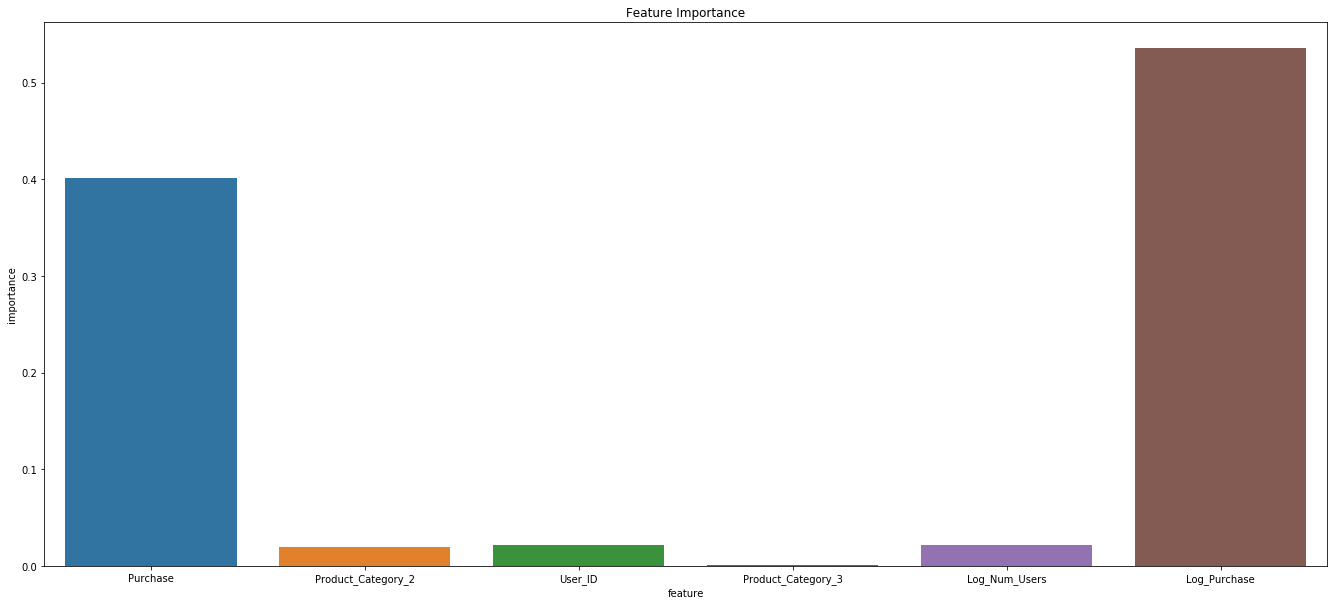

In [14]:
# Feature Importance Exploration for RF
importances = clf.feature_importances_
imp = pd.DataFrame()
imp['feature'], imp['importance'] = X_train.columns, importances
print("Feature ranking:")
print(imp.sort_values(by='importance', ascending=False))
plt.figure(figsize=(23, 10))
sns.barplot(x='feature', y='importance', data=imp)
plt.title('Feature Importance')
plt.show()

In [15]:
df_test.head()

,Product_ID,Purchase,Product_Category_1,Product_Category_2,User_ID,Product_Category_3,Log_Num_Users,Log_Purchase
0,P00000142,13716,-1,4,1130,5,7.029973,9.526318
1,P00000242,16503,-1,4,371,9,5.916202,9.711297
2,P00000342,8896,-1,14,238,0,5.472271,9.093357
3,P00000442,8891,-1,8,92,0,4.521789,9.092795
4,P00000542,8903,-1,0,146,0,4.983607,9.094144


In [16]:
df_test1 = df_test.copy().drop(columns=['Product_ID','Product_Category_1'])
# df_test1 = df_test1.drop('Product_ID', axis=1)
df_test1.head()

,Purchase,Product_Category_2,User_ID,Product_Category_3,Log_Num_Users,Log_Purchase
0,13716,4,1130,5,7.029973,9.526318
1,16503,4,371,9,5.916202,9.711297
2,8896,14,238,0,5.472271,9.093357
3,8891,8,92,0,4.521789,9.092795
4,8903,0,146,0,4.983607,9.094144


In [17]:
prediction_dt = clf.predict(df_test1)
prediction_rf = rf.predict(df_test1)
prediction_vt = voting_clf.predict(df_test1)
prediction_bag = bag.predict(df_test1)

In [24]:
# np.set_printoptions(threshold=np.inf)

In [18]:
lst = [["dt",prediction_dt], ["rf",prediction_rf], ["vt",prediction_vt], ["bg",prediction_bag]]
for i in range(len(lst)):
    df = pd.DataFrame({
        'Product_ID': df_test['Product_ID'],
        'Product_Category_1': lst[i][1]})
    df.to_csv('submission_file_'+lst[i][0]+'.csv', index=False) 